## Clinical-Trial Survival Analysis for Treatment Efficiency

## About This Project

This project focuses on Survival Analysis, a powerful set of statistical methods used to analyze the time until an event occurs—such as death, disease recurrence, or recovery. It is widely applied in clinical research, public health, and many fields where understanding “time-to-event” data is crucial.

In this project, we use a dataset (the same one provided in our online session) to explore how different treatments influence survival time. The goal is to:

Estimate survival probabilities over time

Statistically compare treatments

Identify factors affecting patient outcomes

Handle real-world complexities like time-varying risks and competing events

## Methods Used
1. Kaplan–Meier Survival Curves: 
  Used to visually represent the survival probability over time for different treatment groups.Gives a first look at which treatment might be more effective.

2. Log-Rank Test: 
   A hypothesis test to compare survival curves. Helps assess whether the differences seen in Kaplan-Meier plots are statistically significant.

3. Cox Proportional Hazards Model: A regression model that assesses how multiple factors (covariates) impact survival. Outputs hazard ratios for each covariate, showing their influence on risk. Assumes the effect of   variables does not change over time.

4. Time-Varying Covariate Model: An extension of the Cox model to handle changing patient conditions. More realistic for clinical settings where a patient’s status (e.g., blood pressure) may change during the study.

5. Stratified Cox Model: Used when some variables (like age group or gender) affect baseline risk differently Allows different baseline hazards across strata, while still estimating other covariates' effects.

6. Competing Risks Model: Recognizes that a patient may experience different types of events (e.g., death from different causes). Provides more accurate survival probabilities when multiple outcomes are possible.

Installing quiet used in this project

In [1]:
!pip install lifelines --quiet

  DEPRECATION: Building 'autograd-gamma' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autograd-gamma'. Discussion can be found at https://github.com/pypa/pip/issues/6334


The **lifelines** package offers essential tools for survival analysis, including:

- **KaplanMeierFitter** – for estimating non-parametric survival curves.
- **CoxPHFitter** – for performing regression analysis on survival data using the Cox Proportional Hazards model.
- **logrank_test** – for statistically comparing survival functions between different groups.

In [2]:
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')
df

,ID,TIME,Y,trt,celltype,karno,diagtime,age,priortherapy
0,1,0,0,standard,squamous,60,7,69,no
1,1,72,1,standard,squamous,60,7,69,no
2,2,0,0,standard,squamous,70,5,64,yes
3,2,411,1,standard,squamous,70,5,64,yes
4,3,0,0,standard,squamous,60,3,38,no
...,...,...,...,...,...,...,...,...,...
269,135,231,1,test,large,70,18,67,yes
270,136,0,0,test,large,80,4,65,no
271,136,378,1,test,large,80,4,65,no
272,137,0,0,test,large,30,3,37,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


## 1. Kaplan–Meier Survival Curve


The Kaplan-Meier method is a simple yet powerful tool used to estimate how long individuals remain free from a specific event, like death or relapse. It creates a step-like graph called a survival curve, which shows the chance of surviving over time. One of its strengths is that it works well even when some participants drop out or haven’t experienced the event by the end of the study (this is called censored data). This method is especially helpful when comparing how different treatments affect survival.

Purpose: Estimate the probability of survival over time, even when some data is censored (i.e., the event hasn't occurred for some subjects during the study period).


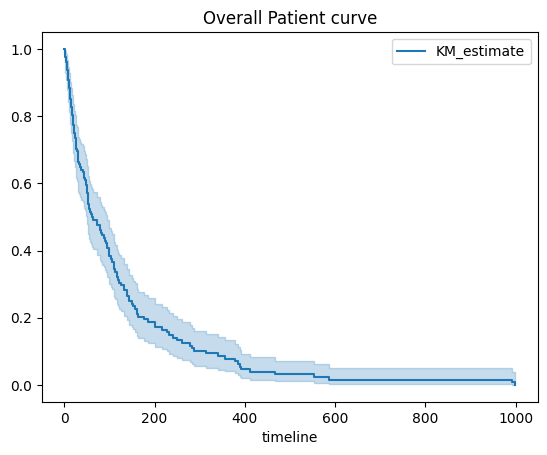

In [5]:
kmf=KaplanMeierFitter()
#separate your event(y=1 or y=0)
df_event=df[df['Y']==1]

#for overall patient curve
kmf.fit(durations=df_event['TIME'],event_observed=df_event['Y'])
kmf.plot_survival_function()
plt.title('Overall Patient curve')
plt.show()

### Comparing Patient Survival Rates: Treated vs. Untreated Groups

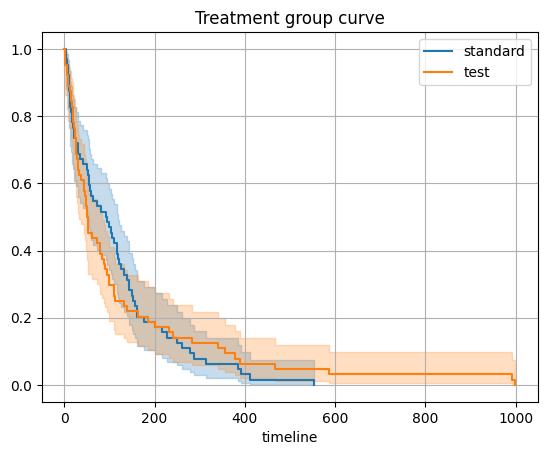

In [6]:
#curve according to treatment group
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=trt_group)
  kmf.plot_survival_function()
plt.grid()
plt.title('Treatment group curve')
plt.show()

### **Conclusion**

Competing risks analysis provides a more accurate estimation of the probability of different types of events over time, essential when multiple outcomes are possible.

## Median Survival Time


Median survival time is the point in time when half of the participants in a study have experienced the event being studied, such as death or relapse. This value is taken from the Kaplan-Meier survival curve and provides a simple way to compare how well different treatments work. If one group has a longer median survival time, it means that people in that group generally stayed event-free for a longer period, suggesting better treatment outcomes.



In [7]:
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=str(trt_group)+'median='+str(np.median(df_event[mask]['TIME'])))
  print(f"Median survival time for {trt_group} is {np.median(df_event[mask]['TIME'])}")

Median survival time for standard is 93.5
Median survival time for test is 51.5


## 2. Log-Rank Test
The Log-Rank Test is a commonly used statistical test in survival analysis to compare the survival curves of two or more groups. It helps determine whether there is a significant difference in the time it takes for an event (like death, recovery, or relapse) to occur between these groups. The test looks at the number of events observed versus expected at each time point and combines this information to produce a test statistic and p-value. If the p-value is low (typically less than 0.05), it suggests that the survival experiences of the groups are significantly different. This test is especially useful when evaluating the effectiveness of different treatments or interventions.

**Purpose:** Statistically compare the survival distributions of two or more groups to determine if there are significant differences.

In [8]:
from lifelines.statistics import logrank_test
group1=df_event[df_event['trt']=='standard']
group2=df_event[df_event['trt']=='test']
results=logrank_test(group1['TIME'],group2['TIME'],event_observed_A=group1['Y'],event_observed_B=group2['Y'])
print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


### Conclusion

The Log-Rank Test was used to statistically validate the differences observed in the Kaplan-Meier curves. By comparing survival distributions between different treatment groups, it confirmed whether these differences were significant or merely due to chance.

### 3. Cox Proportional Hazards Model

The Cox Proportional Hazards Model is a widely used method in survival analysis that examines how different variables affect the time until an event occurs, such as death or recovery. It estimates the risk (hazard) of the event at any given time, assuming that the effect of each variable stays constant throughout the study. This model is helpful when analyzing the impact of multiple factors at once, making it easier to identify which ones truly influence survival.



In [9]:
from lifelines import CoxPHFitter
#prepare wide-formate data: one row per subject
df_wide=df_event.copy()
#Encode categorical variables
df_wide=pd.get_dummies(df_wide,columns=['trt','celltype','priortherapy'],drop_first=True)

<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-06-05 16:58:54 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

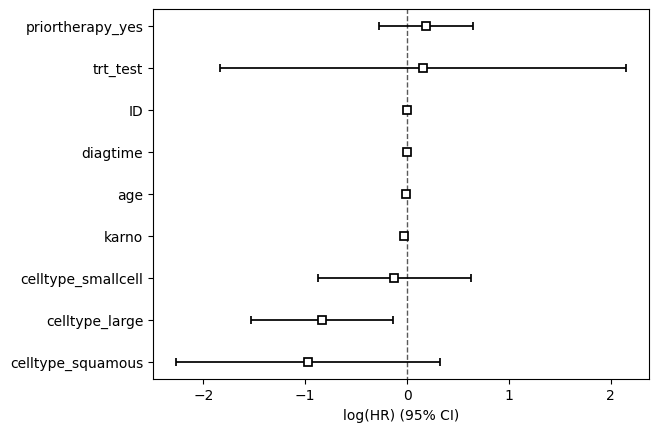

In [10]:
cph=CoxPHFitter()
cph.fit(df_wide,duration_col='TIME',event_col='Y')
cph.print_summary()
cph.plot()
plt.show()
#if hazard score is >1 then higher risk and <1 less risk

### Conclusion

he Cox Proportional Hazards Model allowed for a more detailed exploration of the impact of covariates on survival. It showed how treatment, patient health, and other factors influenced the risk of events, helping to pinpoint key drivers of survival outcomes. The model’s assumptions of constant effects over time provided valuable insight into patient prognosis.

## 4. Stratified Cox Model

The Stratified Cox Model is a modified version of the regular Cox model used when different groups in the data (like cancer types or age groups) have different starting risk levels. Instead of forcing all groups to follow the same baseline risk pattern, this model allows each group to have its own baseline hazard. At the same time, it still measures how other factors (like treatment or prior therapy) affect survival across all groups. This method is especially useful when the usual Cox model assumptions don’t hold because the risk patterns vary too much between groups.


In [11]:
df_encoded = pd.get_dummies(df, columns=['trt', 'priortherapy'], drop_first=True)

# Fit Stratified Cox Model using 'celltype' as the strata
cph_strat = CoxPHFitter()
cph_strat.fit(df_encoded, duration_col='TIME', event_col='Y', strata=['celltype'])
cph_strat.print_summary()


<lifelines.CoxPHFitter: fitted with 274 total observations, 146 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
                   strata = celltype
      baseline estimation = breslow
   number of observations = 274
number of events observed = 128
   partial log-likelihood = -315.99
         time fit was run = 2025-06-05 16:58:54 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
ID                0.02      1.02      0.02           -0.01            0.05                0.99                1.05
karno            -0.04      0.96      0.01           -0.05           -0.03                0.95                0.97
diagtime         -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
age              -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
trt_test         -0.90      0.41      1.09           -3.03            1.24                0.05                3.44
priortherapy_yes  0.22      1.24      0.24           -0.25            0.69                0.78                1.99

                  cmp to     z      p  -log2(p)
covariate                                      
ID                  0.00  1.11   0.27      1.90
karno               0.00 -6.52 <0.005     33.73
diagtime            0.00 -0.60   0.55      0.86
age                 0.00 -1.41   0.16      2.65
trt_test            0.00 -0.82   0.41      1.29
priortherapy_yes    0.00  0.90   0.37      1.44
---
Concordance = 0.71
Partial AIC = 643.99
log-likelihood ratio test = 45.48 on 6 df
-log2(p) of ll-ratio test = 24.67

### Conclusion

The Stratified Cox Model provided a way to address varying baseline risks across different patient groups, such as those with different cancer cell types. This model adjusted for these differences, allowing for a better comparison of the effects of other covariates across groups.

## 5. Time-Varying Survival Analysis


Time-varying survival analysis is used when certain factors, like treatment status or patient health, change over time and affect survival outcomes. Unlike traditional models that assume these factors stay constant, time-varying analysis takes into account these changes throughout the study period. This allows for a more accurate and detailed understanding of how evolving factors influence survival, offering a better representation of real-world conditions where patient circumstances can shift over time.

In [ ]:

df_start=df[df['Y']==0].copy() 
df_event=df[df['Y']==1].copy() 


df_event=df_event.rename(columns={"TIME":"stop","Y":"event"})
df_start=df_start.rename(columns={"TIME":"start"})

df_timevarying=pd.merge(df_start,df_event[["ID","stop","event"]],on="ID")
df_timevarying=pd.get_dummies(df_timevarying,columns=['trt','celltype','priortherapy'],drop_first=True)

#final check
print(df_timevarying[["ID","start","stop","event"]].head())

   ID  start  stop  event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1


In [13]:
#check there is null value
print(df_timevarying.isnull().sum())
#ensure y is not in the modeling data
if 'Y' in df_timevarying.columns:
   df_timevarying.drop(columns=['Y'],inplace=True)


ID                    0
start                 0
Y                     0
karno                 0
diagtime              0
age                   0
stop                  0
event                 0
trt_test              0
celltype_large        0
celltype_smallcell    0
celltype_squamous     0
priortherapy_yes      0
dtype: int64


## Cox Time-Varying Coefficient Model



The Cox Time-Varying Coefficient Model builds on the standard Cox model by allowing the effect of covariates to change over time. This flexibility makes it possible to study how factors, such as treatment or patient health, dynamically influence the risk of an event throughout the study period. The model uses the CoxTimeVaryingFitter to handle this time-varying nature, incorporating patient IDs, event occurrences, and time intervals (start, stop) for the analysis. The results, including the model summary and coefficient plots, help us interpret how the impact of covariates evolves over time.


<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'event'
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -465.24
  time fit was run = 2025-06-05 16:58:55 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.36      1.44      0.21           -0.05            0.77                0.95                2.17
celltype_large     -0.80      0.45      0.30           -1.38           -0.21                0.25                0.81
celltype_smallcell -0.18      0.84      0.28           -0.72            0.36                0.49                1.44
celltype_squamous  -1.10      0.33      0.30           -1.68           -0.51                0.19                0.60
priortherapy_yes    0.18      1.19      0.23           -0.28            0.63                0.76                1.88

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -6.07 <0.005     29.52
diagtime              0.00 -0.45   0.65      0.61
age                   0.00 -1.53   0.12      3.00
trt_test              0.00  1.72   0.08      3.56
celltype_large        0.00 -2.65   0.01      6.95
celltype_smallcell    0.00 -0.65   0.52      0.96
celltype_squamous     0.00 -3.66 <0.005     11.94
priortherapy_yes      0.00  0.76   0.45      1.17
---
Partial AIC = 946.47
log-likelihood ratio test = 62.34 on 8 df
-log2(p) of ll-ratio test = 32.53

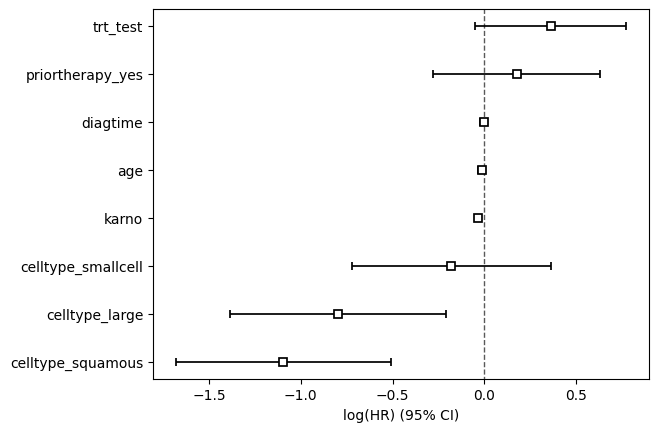

In [14]:
#When patient condition changes over time
from lifelines import CoxTimeVaryingFitter
ctv=CoxTimeVaryingFitter()
ctv.fit(df_timevarying,id_col='ID',event_col='event',start_col='start',stop_col='stop')
ctv.print_summary()
ctv.plot()
plt.show()

## Kaplan-Meier Time-Varying Analysis


In this step, Kaplan-Meier survival curves are generated to compare survival probabilities across different patient cell types over time. For each unique cell type, the data is filtered accordingly, and the Kaplan-Meier estimator is applied using the TIME (duration) and Y (event occurrence) variables. The resulting survival functions are plotted to visually represent how the likelihood of survival changes over time for each cell type, allowing for a direct comparison of survival outcomes across these groups.



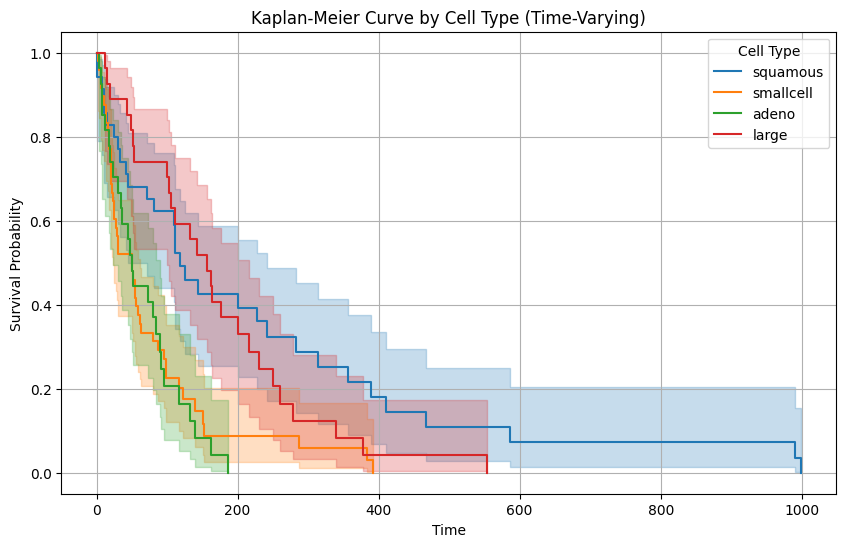

In [15]:
plt.figure(figsize=(10, 6))
for cell in df['celltype'].unique():
    mask = df['celltype'] == cell
    kmf.fit(df[mask]['TIME'], event_observed=df[mask]['Y'], label=cell)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Curve by Cell Type (Time-Varying)')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='Cell Type')
plt.grid(True)
plt.show()

## Log-Rank Test for Time-Varying Groups



The Log-Rank Test is used to compare the survival distributions between two patient groups with different cell types, specifically squamous and small cell lung cancer. By utilizing the TIME (duration) and Y (event occurrence) variables, the test assesses whether there is a significant difference in survival times between these groups. The results of the test help determine if one group has longer survival and whether the difference observed is statistically significant or just a random variation.





In [ ]:
group1 = df[df['celltype'] == 'squamous']
group2 = df[df['celltype'] == 'smallcell']

results = logrank_test(group1['TIME'], group2['TIME'],
                       event_observed_A=group1['Y'], event_observed_B=group2['Y'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.57 <0.005     10.55

## Competing Risk



Competing risks refer to events that can prevent the primary event of interest from occurring. For example, in a clinical study, a patient might either die from lung cancer (the primary event) or from an unrelated cause like a heart attack (a competing event). Once one event happens, the other cannot occur. If competing risks are not accounted for in survival analysis, the results may become biased or misleading, especially if these competing events are common.




## Conclusion

In this project, various survival analysis techniques were applied to assess outcomes in lung cancer patients. The Kaplan-Meier curves provided a visual comparison of survival across treatment groups, and the Log-Rank Test confirmed these differences were statistically significant. The Cox Proportional Hazards Model helped identify key factors, such as treatment type and patient condition, that influence survival. The Time-Varying Covariate Model addressed how these factors change over time. The Stratified Cox Model accounted for differences in baseline risks between cancer cell types, and the Fine-Gray Competing Risks Model considered mortality from causes other than lung cancer.
